# Data for TSP Warehouse

In [164]:
import pandas as pd
import numpy as np
import os
#from ipycanvas import Canvas, Path2D


In [165]:
df = pd.read_csv('fruits.csv')
df

,Name,Category
0,Abiu,Fruit
1,Açaí,Fruit
2,Acerola,Fruit
3,Akebi,Fruit
4,Ackee,Fruit
...,...,...
153,Pea,Fruit
154,Pumpkin,Fruit
155,Squash,Fruit
156,Tomato,Fruit


# Generate Graph

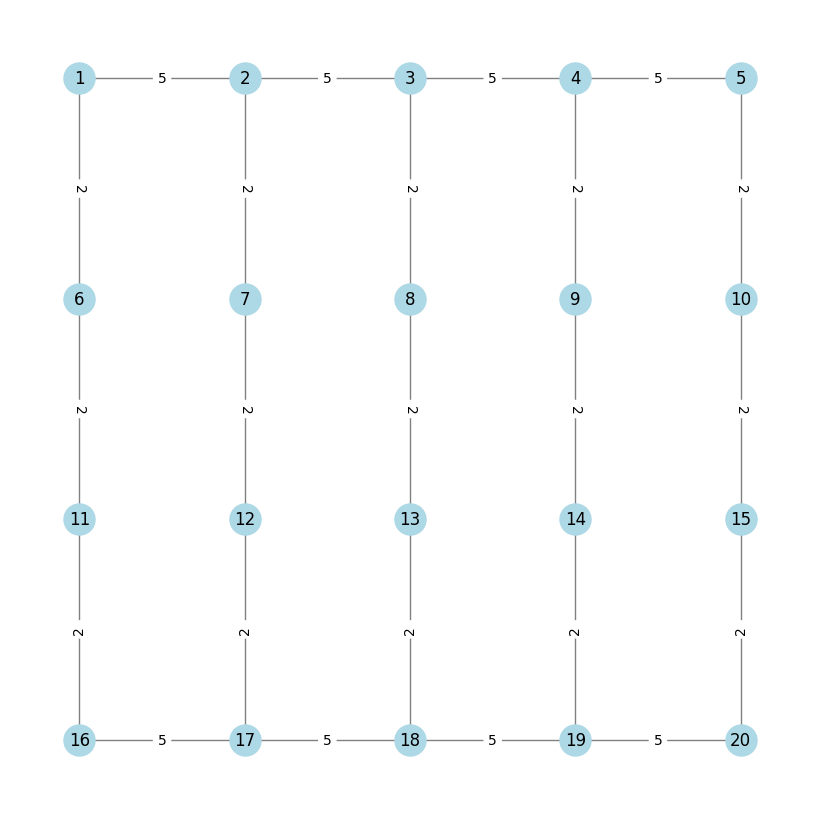

In [254]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.Graph()

# Define grid dimensions
n = 5  # Number of rows
m = 4  # Number of columns
n_bins = n * m

# Add edges within rows
for i in range(1, n):
    G.add_edge(i, i + 1, weight=5)

for i in range(n * m - n + 1, n * m):
    G.add_edge(i, i + 1, weight=5)

# Add edges between rows
for i in range(1, n * m - n + 1):
    G.add_edge(i, i + n, weight=2)
    
# Visualize the graph
pos = {}
for row in range(m):  # m is the number of rows
    for col in range(n):  # n is the number of columns
        node = row * n + col + 1
        pos[node] = (col, -row)  # Arrange nodes in a square grid

# Highlight the shortest path in the visualization
plt.figure(figsize=(8, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="lightblue",
    edge_color="gray",
)

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)},
    font_size=10,
    label_pos=0.5,
)
plt.axis("off")
plt.show()

# Assign fruit to bins

In [167]:
# new column with random integer
df['bin'] = np.random.randint(1, n_bins, df.shape[0])

In [168]:
# Generate work orders
wos = 100

# Check if wos file is already generated
if f'wos_{wos}.parquet' in os.listdir():
    df_wo = pd.read_parquet(f'wos_{wos}.parquet')
    print(f'Loaded {df_wo.shape[0]} work orders')
else:
    print(f'Generating {wos} work orders')
    df_wo = pd.DataFrame(columns=df.columns)
    for _ in range(wos):
        random_row = df.sample()
        df_wo = pd.concat([df_wo, random_row], ignore_index=True)
    df_wo.to_parquet(f'wos_{wos}.parquet')
df_wo.head()

Loaded 100 work orders


,Name,Category,bin
0,Japanese plum,Fruit,19
1,Mandarine,Fruit,5
2,Cherimoya (Custard Apple),Fruit,16
3,Grape,Fruit,10
4,Cucumber,Fruit,5


In [169]:
batch_size = 10
fetch_list = []
for i in range(int(np.floor(df_wo.count().Category) / batch_size)):
    fetch_list.append(df_wo.loc[i*10:i*10 + 10])

In [170]:
# Traveling Salesman applied to a pickup list
salesman =  []
pickup_point = [1]
for i in fetch_list:
    pickup_list = pickup_point + i.bin.values.tolist()
    tsp = nx.approximation.traveling_salesman_problem
    tsp_route  = tsp(G, nodes=pickup_list)
    tsp_distance = sum(G[u][v]["weight"] for u, v in zip(tsp_route, tsp_route[1:]))
    seen = set()
    order = [node for node in tsp_route if node in pickup_list and not (node in seen or seen.add(node))][1:]

    salesman.append({'pickup_list': pickup_list, 'tsp_route': tsp_route, 'tsp_distance': tsp_distance, 'pickup_order': order})
# Convert salesman list to dataframe
df_salesman = pd.DataFrame(salesman)
df_salesman.head()

,pickup_list,tsp_route,tsp_distance,pickup_order
0,"[1, 19, 5, 16, 10, 5, 3, 10, 6, 12, 2, 19]","[1, 2, 7, 12, 7, 2, 3, 4, 5, 10, 15, 20, 19, 1...",60,"[2, 12, 3, 5, 10, 19, 16, 6]"
1,"[1, 19, 4, 5, 15, 6, 7, 2, 15, 4, 1, 18]","[1, 2, 7, 12, 17, 18, 19, 14, 9, 4, 5, 10, 15,...",64,"[2, 7, 18, 19, 4, 5, 15, 6]"
2,"[1, 18, 7, 5, 14, 8, 2, 6, 7, 5, 2, 3]","[1, 2, 3, 8, 13, 18, 19, 14, 9, 4, 5, 4, 3, 2,...",60,"[2, 3, 8, 18, 14, 5, 7, 6]"
3,"[1, 3, 16, 15, 5, 19, 10, 2, 18, 6, 7, 6]","[1, 2, 3, 4, 5, 10, 15, 20, 19, 18, 13, 8, 3, ...",64,"[2, 3, 5, 10, 15, 19, 18, 7, 16, 6]"
4,"[1, 6, 8, 10, 6, 5, 14, 2, 6, 6, 5, 2]","[1, 2, 3, 8, 13, 18, 19, 14, 9, 4, 5, 10, 5, 4...",60,"[2, 8, 14, 5, 10, 6]"


In [171]:
# Stats
print(f"Total number of work orders: {df_wo.count().Category}")
print(f"Total number of batches: {len(fetch_list)}")
print(f"Average Distance: {df_salesman.tsp_distance.mean()}")


Total number of work orders: 100
Total number of batches: 10
Average Distance: 60.6


# Generating a more complex warehouse

In [172]:
import itertools

def ccw(A, B, C):
    """Check if three points are counter-clockwise"""
    return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

def segments_intersect(seg1, seg2):
    """Check if two segments intersect"""
    p1, p2 = seg1['coord']
    q1, q2 = seg2['coord']
    return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

def intersection_point(seg1, seg2):
    """Find intersection point of two segments, assuming they intersect"""
    p1, p2 = seg1['coord']
    q1, q2 = seg2['coord']

    A1, B1, C1 = p2[1] - p1[1], p1[0] - p2[0], (p2[1] - p1[1]) * p1[0] + (p1[0] - p2[0]) * p1[1]
    A2, B2, C2 = q2[1] - q1[1], q1[0] - q2[0], (q2[1] - q1[1]) * q1[0] + (q1[0] - q2[0]) * q1[1]

    det = A1 * B2 - A2 * B1
    if det == 0:  # Parallel lines
        return None
    
    x = (B2 * C1 - B1 * C2) / det
    y = (A1 * C2 - A2 * C1) / det

    # Check if within segment bounds
    if min(p1[0], p2[0]) <= x <= max(p1[0], p2[0]) and min(p1[1], p2[1]) <= y <= max(p1[1], p2[1]) and \
       min(q1[0], q2[0]) <= x <= max(q1[0], q2[0]) and min(q1[1], q2[1]) <= y <= max(q1[1], q2[1]):
        return (x, y)
    
    return None

def find_intersections(vecs):
    """Find all intersection points in a list of 2D line segments"""
    intersections = []
    for seg1, seg2 in itertools.combinations(vecs, 2):
        if segments_intersect(seg1, seg2):
            point = intersection_point(seg1, seg2)
            if point:
                intersections.append({'point': point, 'segment1': seg1['id'], 'segment2': seg2['id']})
    return intersections




In [173]:
# Define vectors
vecs = []
vecs.append({'id': 'A', 'coord': ((0,0), (10,0))})  # Horizontal line
vecs.append({'id': 'B', 'coord': ((5,0), (5,5))})   # Vertical line

# Find intersections
intersections = find_intersections(vecs)

# Display results
for inter in intersections:
    print(f"Intersection at {inter['point']} between segment {inter['segment1']} and segment {inter['segment2']}")
    

Intersection at (5.0, 0.0) between segment A and segment B


[(5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]

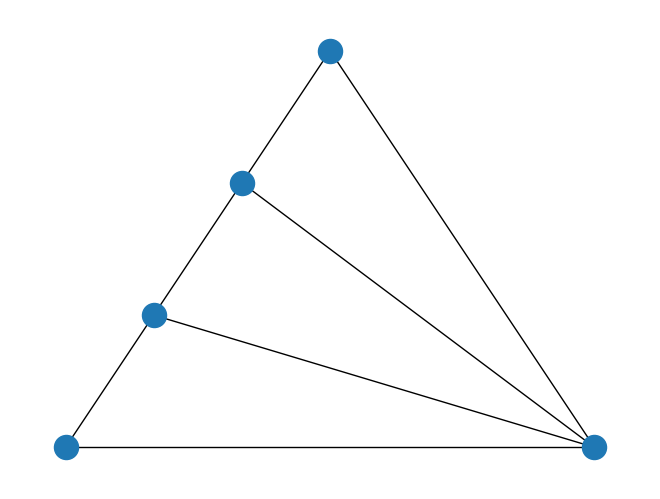

In [ ]:
G = nx.Graph([(1, 2), (2, 3), (3, 4)])
# Grow graph by one new node, adding edges to all existing nodes.
# wrong way - will raise RuntimeError
# G.add_edges_from(((5, n) for n in G.nodes))
# correct way - note that there will be no self-edge for node 5
G.add_edges_from(list((5, n) for n in G.nodes))
pos = nx.planar_layout(G)
nx.draw(G, pos=pos) 
list((5, n) for n in G.nodes)

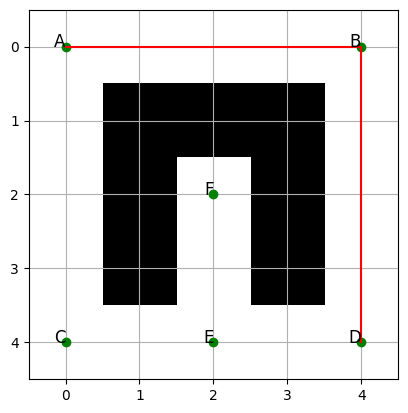

In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define the 2D grid environment
grid = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0]
])

# Define waypoints as (x, y) coordinates
waypoints = {
    'A': (0, 0),
    'B': (0, 4),
    'C': (4, 0),
    'D': (4, 4),
    'E': (4, 2),
    'F': (2, 2),
}

# Initialize an undirected graph
G = nx.Graph()

# Add nodes for each waypoint
for key, coord in waypoints.items():
    G.add_node(key, pos=coord)

# Function to check if the path between two points is clear
def is_path_clear(start, end, grid):
    x1, y1 = start
    x2, y2 = end
    
    # Bresenham's line algorithm
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy
    
    while (x1, y1) != (x2, y2):
        if grid[x1, y1] == 1:
            return False
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy
    return grid[x2, y2] == 0

# Add edges between waypoints if the path is clear
for wp1 in waypoints:
    for wp2 in waypoints:
        if wp1 != wp2:
            if is_path_clear(waypoints[wp1], waypoints[wp2], grid):
                dist = np.linalg.norm(np.array(waypoints[wp1]) - np.array(waypoints[wp2]))
                G.add_edge(wp1, wp2, weight=dist)

# Ensure that 'E' is reachable by connecting it to more adjacent waypoints
for neighbor in ['A', 'B', 'C', 'D']:
    if is_path_clear(waypoints['E'], waypoints[neighbor], grid):
        G.add_edge('E', neighbor, weight=np.linalg.norm(np.array(waypoints['E']) - np.array(waypoints[neighbor])))

# Implement A* Algorithm
def heuristic(a, b):
    x1, y1 = G.nodes[a]['pos']
    x2, y2 = G.nodes[b]['pos']
    return np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2]))

# Find the shortest path from A to E
path = nx.astar_path(G, 'A', 'D', heuristic=heuristic, weight='weight')

# Plot the grid
plt.imshow(grid, cmap='gray_r')
plt.grid(True)

# Plot waypoints
for key, (x, y) in waypoints.items():
    plt.plot(y, x, 'go')  # 'go' for green circles
    plt.text(y, x, key, fontsize=12, ha='right')

# Plot the path
path_coords = [waypoints[wp] for wp in path]
path_coords = np.array(path_coords)
plt.plot(path_coords[:, 1], path_coords[:, 0], 'r-')  # 'r-' for red line

plt.show()


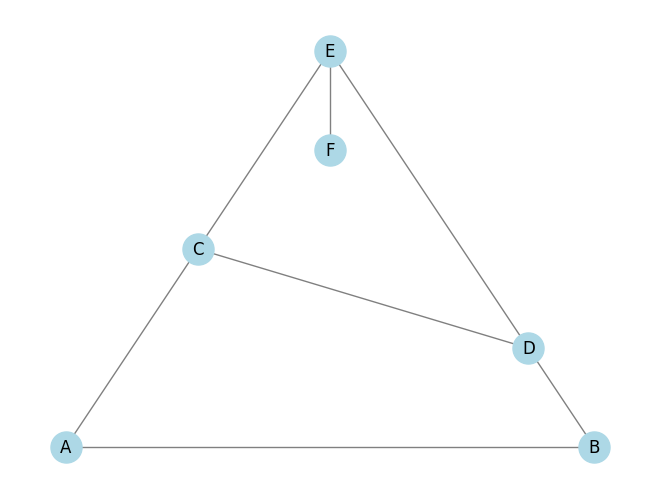

In [18]:
pos = nx.planar_layout(G)
nx.draw(G, pos=pos, with_labels=True, node_size=500, node_color="lightblue", edge_color="gray") 